In [3]:
import sys
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


if ".." not in sys.path:
    sys.path.append("..")

from utils.const import (
    ALL_VARS,
    INTEREST_VARS,
    VARIABLE_COLORS,
    ALL_ZONES,
    GROUPED_DATASETS_PATH,
    SELECTED_ZONES,
)
from utils.plotting import (
    plot_series,
    box_plot,
    hist_plot,
    data_exploration,
)
from utils.stats import (
    print_variable_info,
    describe_variables,
    filter_final_data,
)

from utils.preprocessing import (
    mfill,
    date_fill,
)

from utils.transform import (
    yeo_johnson_transformation,
    log_transformation,
)

In [4]:
REGRESSION_VARS = [
    "date",
    "PM10",
    "PM2.5",
    "WSR",
]

REGRESSION_VARS_NO_DATE = [
    "PM10",
    "PM2.5",
    "WSR",
]

In [5]:
grouped_df: dict[str, pd.DataFrame] = dict()

for zone_path in GROUPED_DATASETS_PATH:
    zone = zone_path.split("/")[-1].split(".")[0].split("_")[0]
    grouped_df.update({zone: pd.read_csv(zone_path, parse_dates=["date"])})

In [6]:
pg.normality(grouped_df['CENTRO'][INTEREST_VARS],method='jarque_bera',alpha=0.05)

,W,pval,normal
PM10,83.154030,0.000000e+00,False
PM2.5,154.036668,0.000000e+00,False
WSR,27.361593,1.144210e-06,False
WDR,162.340146,0.000000e+00,False
PRS,56.974160,4.248824e-13,False


c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:111

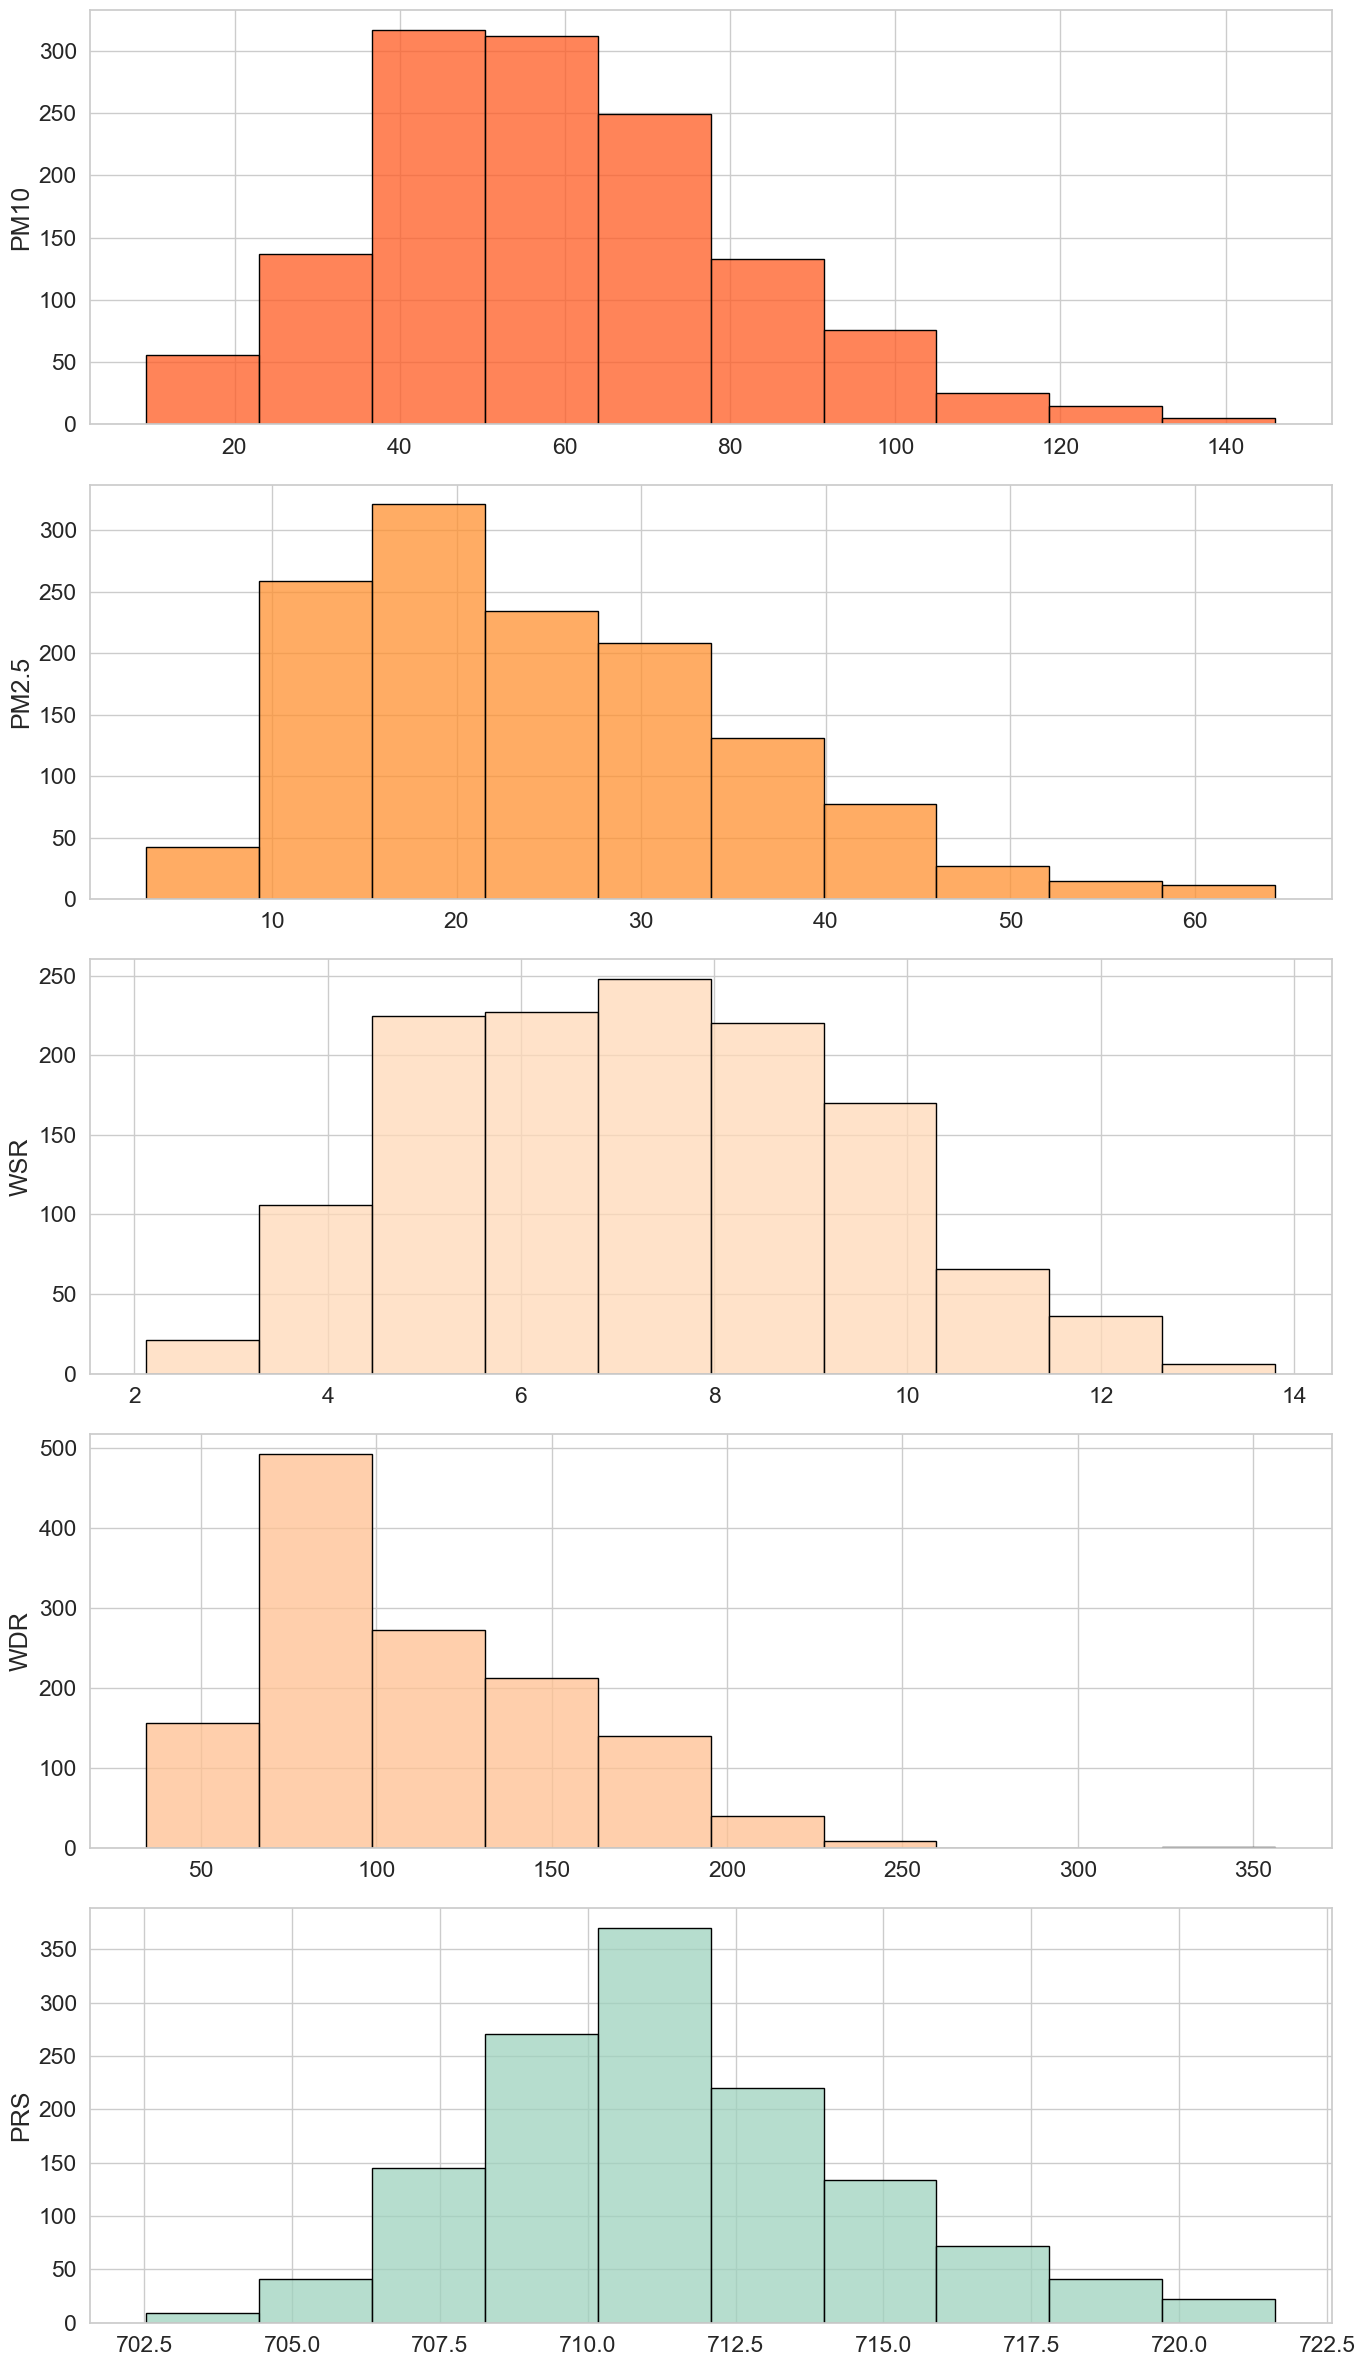

In [7]:
hist_plot(grouped_df['CENTRO'],INTEREST_VARS,title="",bins=10)

In [8]:
# Transformación de los dataframes usando yeo-johnson
transformed_df: dict[str, pd.DataFrame] = dict()
lambda_zonas: dict[str, pd.DataFrame] = dict()
for zone, df in grouped_df.items():
    df_ = df.copy()
    df_ = yeo_johnson_transformation(df_)
    transformed_df.update({zone: df_[0]})
    lambda_zonas.update({zone: df_[1]})
del df_

In [9]:
transformed_df["CENTRO"].head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2020-01-01,1.207314,-0.182098,-0.644331,-0.478069,-1.092729,0.379556,1.160314,-3.608225e-16,0.0,2.546493,-1.116205,-0.341564,-1.619052,-2.492413,1.799856
1,2020-01-02,1.215448,0.538590,-0.378918,-0.013931,-0.514894,-1.141319,-1.946488,-9.020562e-15,0.0,0.763669,-1.025589,-0.224217,-1.143527,-1.794930,1.667402
2,2020-01-03,1.092501,0.259921,-0.509164,-0.220293,0.254169,-0.753972,-1.780167,-1.609823e-15,0.0,-1.073725,-0.476550,-0.190821,-1.037454,0.819831,2.284880
3,2020-01-04,1.070148,0.141189,-0.316094,-0.141683,0.116054,-0.628870,-0.976974,1.196265e-14,0.0,-1.124794,-0.473948,-0.136285,-1.348010,-1.399082,1.609290
4,2020-01-05,1.185898,0.045255,0.058095,0.079224,0.044584,0.196662,0.369157,1.090794e-14,0.0,-0.964147,1.342634,-0.087502,-1.237137,-1.787204,1.453940


In [10]:
# Test de normalidad a las variables de interés
normalidad_df: dict[str, pd.DataFrame] = dict()

for zone, df in transformed_df.items():
    normalidad_df.update({zone: pg.normality(df[INTEREST_VARS],method='jarque_bera',alpha=0.05)})

normalidad_df

{'NORTE2':                W          pval  normal
 PM10    0.367775  8.320294e-01    True
 PM2.5  13.982486  9.199025e-04   False
 WSR     3.314437  1.906685e-01    True
 WDR    62.031176  3.386180e-14   False
 PRS    42.399164  6.210672e-10   False,
 'NOROESTE2':                 W      pval  normal
 PM10     0.226981  0.892713    True
 PM2.5    9.991931  0.006765   False
 WSR      0.208021  0.901216    True
 WDR     17.078044  0.000196   False
 PRS    394.999699  0.000000   False,
 'SURESTE3':                W          pval  normal
 PM10   30.440839  2.453894e-07   False
 PM2.5   1.133661  5.673206e-01    True
 WSR    71.322339  3.330669e-16   False
 WDR     0.027341  9.864225e-01    True
 PRS    61.448704  4.529710e-14   False,
 'CENTRO':                W          pval  normal
 PM10    0.170870  9.181129e-01    True
 PM2.5  10.461728  5.348902e-03   False
 WSR    21.520248  2.122939e-05   False
 WDR    29.971791  3.102474e-07   False
 PRS    40.926010  1.297269e-09   False,
 'NORESTE

c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:111

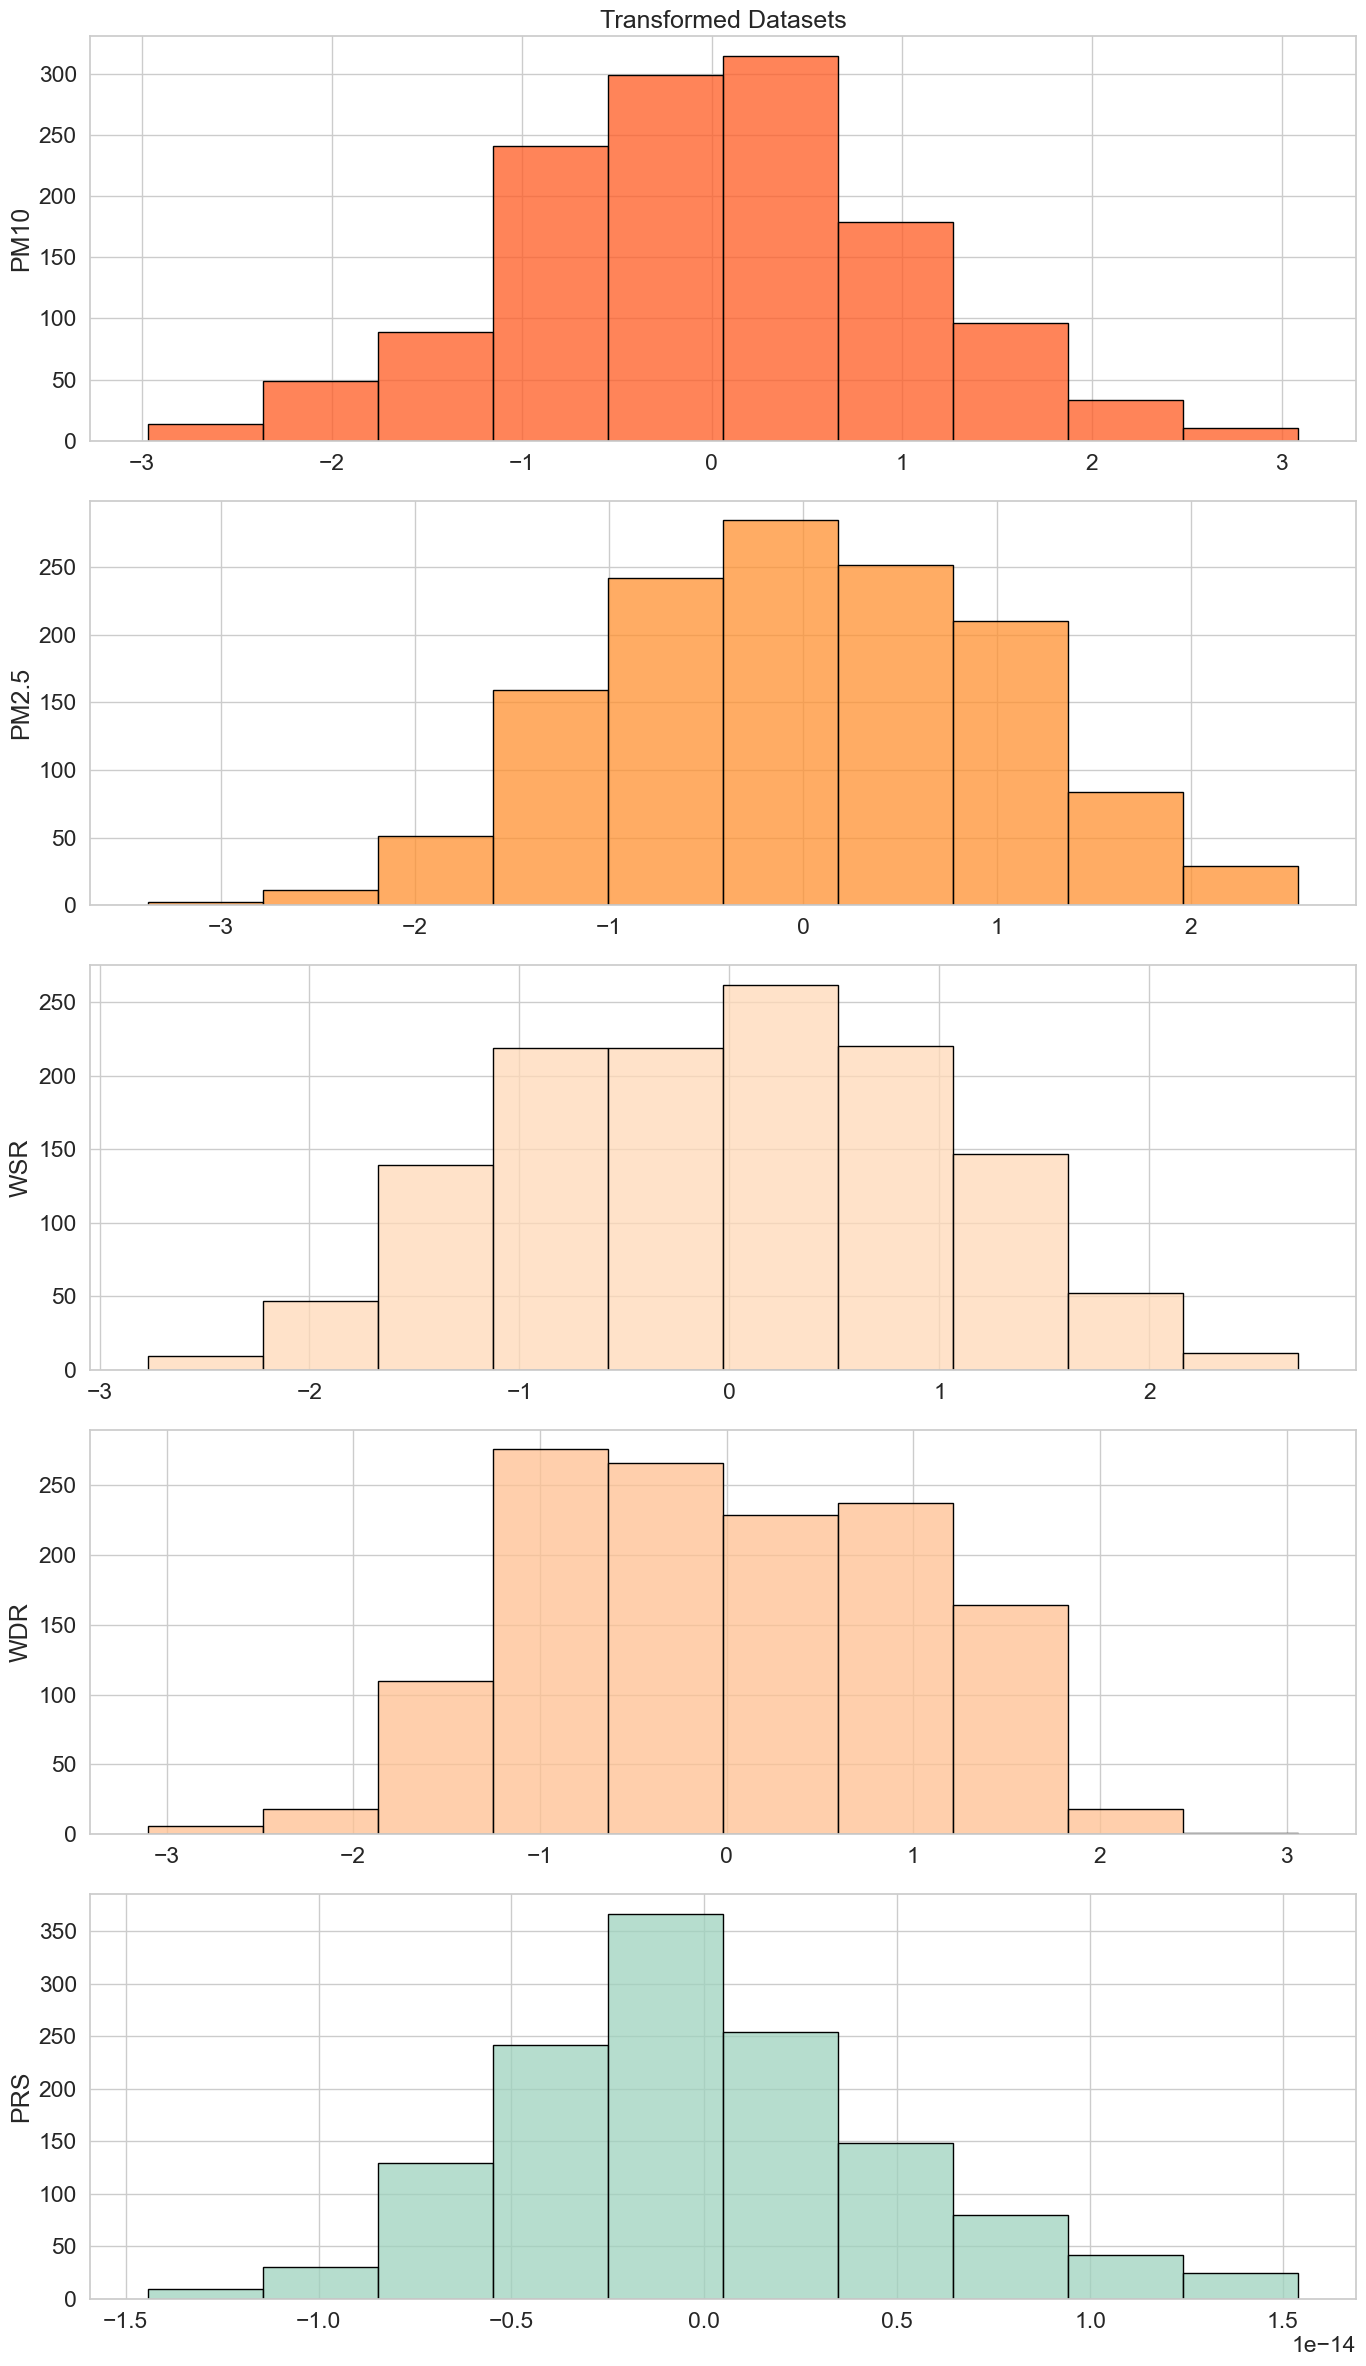

In [11]:
hist_plot(transformed_df['CENTRO'],INTEREST_VARS,"Transformed Datasets",bins=10)

In [12]:
for zone, df in transformed_df.items():
    df.to_csv(f"../../datos/04_yeojohnson_datasets/{zone}_2020_2023.csv", index=False)

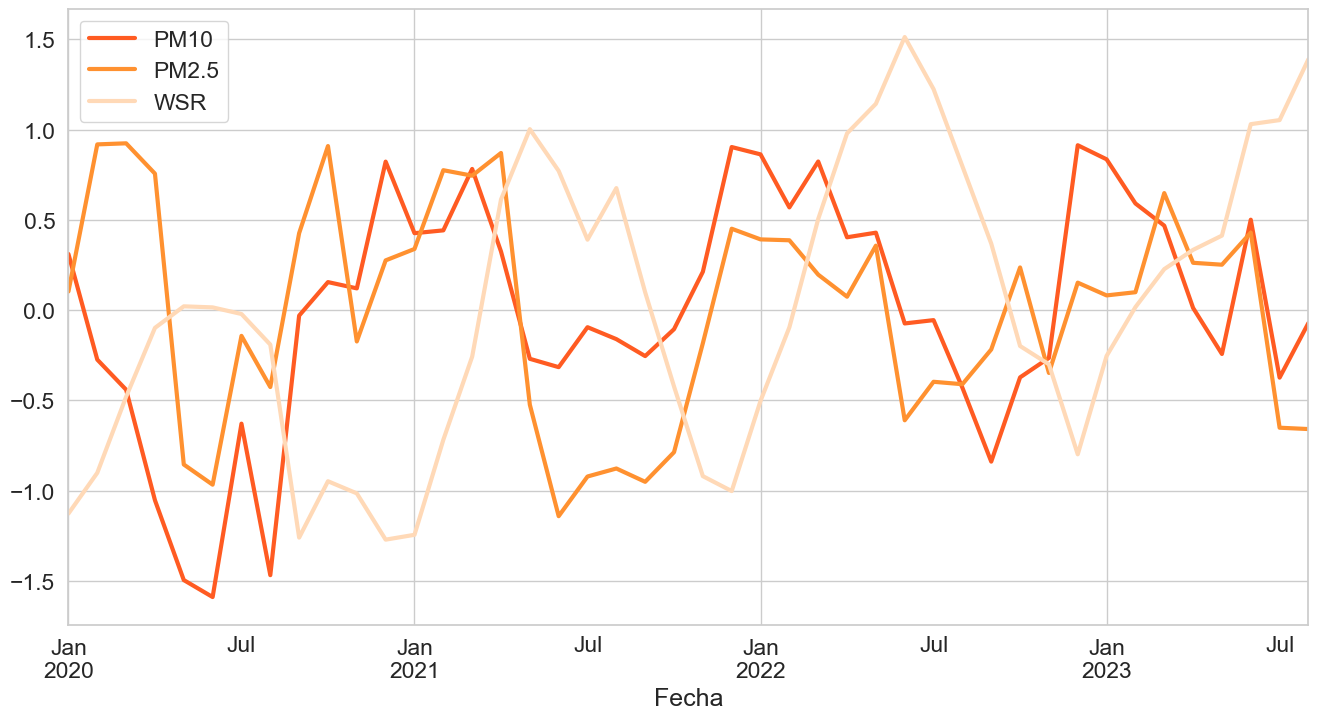

In [13]:
plot_series(transformed_df["CENTRO"], interest_vars=REGRESSION_VARS, title="", freq="M")

## Desestacionalizacion

In [14]:
columns_to_destacionalize = ['PM2.5', 'PM10', 'WSR']
destacionalized_df: dict[str, pd.DataFrame] = dict()

for zone, df in transformed_df.items():
    destacionalized_zone_df = pd.DataFrame(index=df.index)  # DataFrame para almacenar resultados desestacionalizados
    destacionalized_zone_df['date'] = df['date']

    for column in df.columns[1:]:
        destacionalized_zone_df[column] = df[column].diff()


    destacionalized_df[zone] = destacionalized_zone_df

for zone, df in destacionalized_df.items():
    df.drop([0],inplace=True)

In [15]:
destacionalized_df['CENTRO'].head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
1,2020-01-02,0.008134,0.720688,0.265412,0.464137,0.577835,-1.520875,-3.106802,-8.659740e-15,0.0,-1.782824,0.090615,0.117346,0.475525,0.697483,-0.132454
2,2020-01-03,-0.122948,-0.278669,-0.130246,-0.206361,0.769063,0.387346,0.166321,7.410739e-15,0.0,-1.837394,0.549039,0.033397,0.106073,2.614761,0.617477
3,2020-01-04,-0.022353,-0.118731,0.193070,0.078610,-0.138116,0.125102,0.803193,1.357248e-14,0.0,-0.051069,0.002602,0.054536,-0.310556,-2.218913,-0.675590
4,2020-01-05,0.115750,-0.095934,0.374189,0.220907,-0.071469,0.825532,1.346131,-1.054712e-15,0.0,0.160648,1.816582,0.048783,0.110873,-0.388122,-0.155350
5,2020-01-06,0.261182,0.803316,0.799394,0.831056,-0.154963,1.052338,0.468821,-6.522560e-15,0.0,-0.377692,0.515298,0.192730,0.385342,-0.323813,0.155084


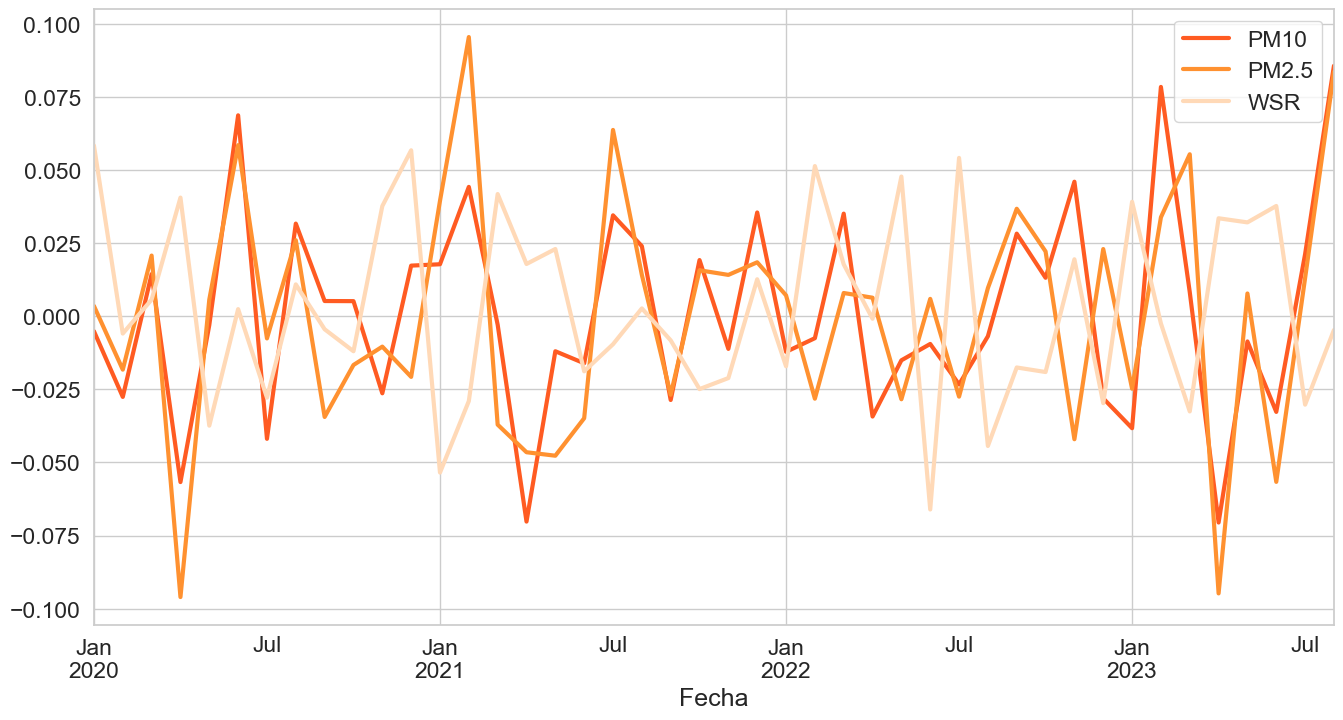

In [16]:
plot_series(destacionalized_df["CENTRO"], interest_vars=REGRESSION_VARS, title="", freq="M")

In [17]:
# Test de normalidad a las variables de interés
normalidad2_df: dict[str, pd.DataFrame] = dict()

for zone, df in destacionalized_df.items():
    normalidad2_df.update({zone: pg.normality(df[INTEREST_VARS],method='jarque_bera',alpha=0.05)})
normalidad2_df

{'NORTE2':                 W          pval  normal
 PM10    59.154769  1.427747e-13   False
 PM2.5  339.537090  0.000000e+00   False
 WSR    404.199552  0.000000e+00   False
 WDR    185.802371  0.000000e+00   False
 PRS    192.736491  0.000000e+00   False,
 'NOROESTE2':                 W          pval  normal
 PM10    55.765689  7.773782e-13   False
 PM2.5   74.454445  1.110223e-16   False
 WSR    244.870185  0.000000e+00   False
 WDR    360.667528  0.000000e+00   False
 PRS    333.681644  0.000000e+00   False,
 'SURESTE3':                 W          pval  normal
 PM10   306.809764  0.000000e+00   False
 PM2.5   65.267409  6.772360e-15   False
 WSR    988.645500  0.000000e+00   False
 WDR     93.853857  0.000000e+00   False
 PRS    228.238427  0.000000e+00   False,
 'CENTRO':                 W          pval  normal
 PM10   153.273003  0.000000e+00   False
 PM2.5   82.000604  0.000000e+00   False
 WSR     54.238220  1.668443e-12   False
 WDR     53.327420  2.630896e-12   False
 PRS    1

In [20]:
for zone, df in destacionalized_df.items():
    df.to_csv(f"../../datos/05_destationalized_datasets/{zone}_2020_2023.csv", index=False)

c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:111

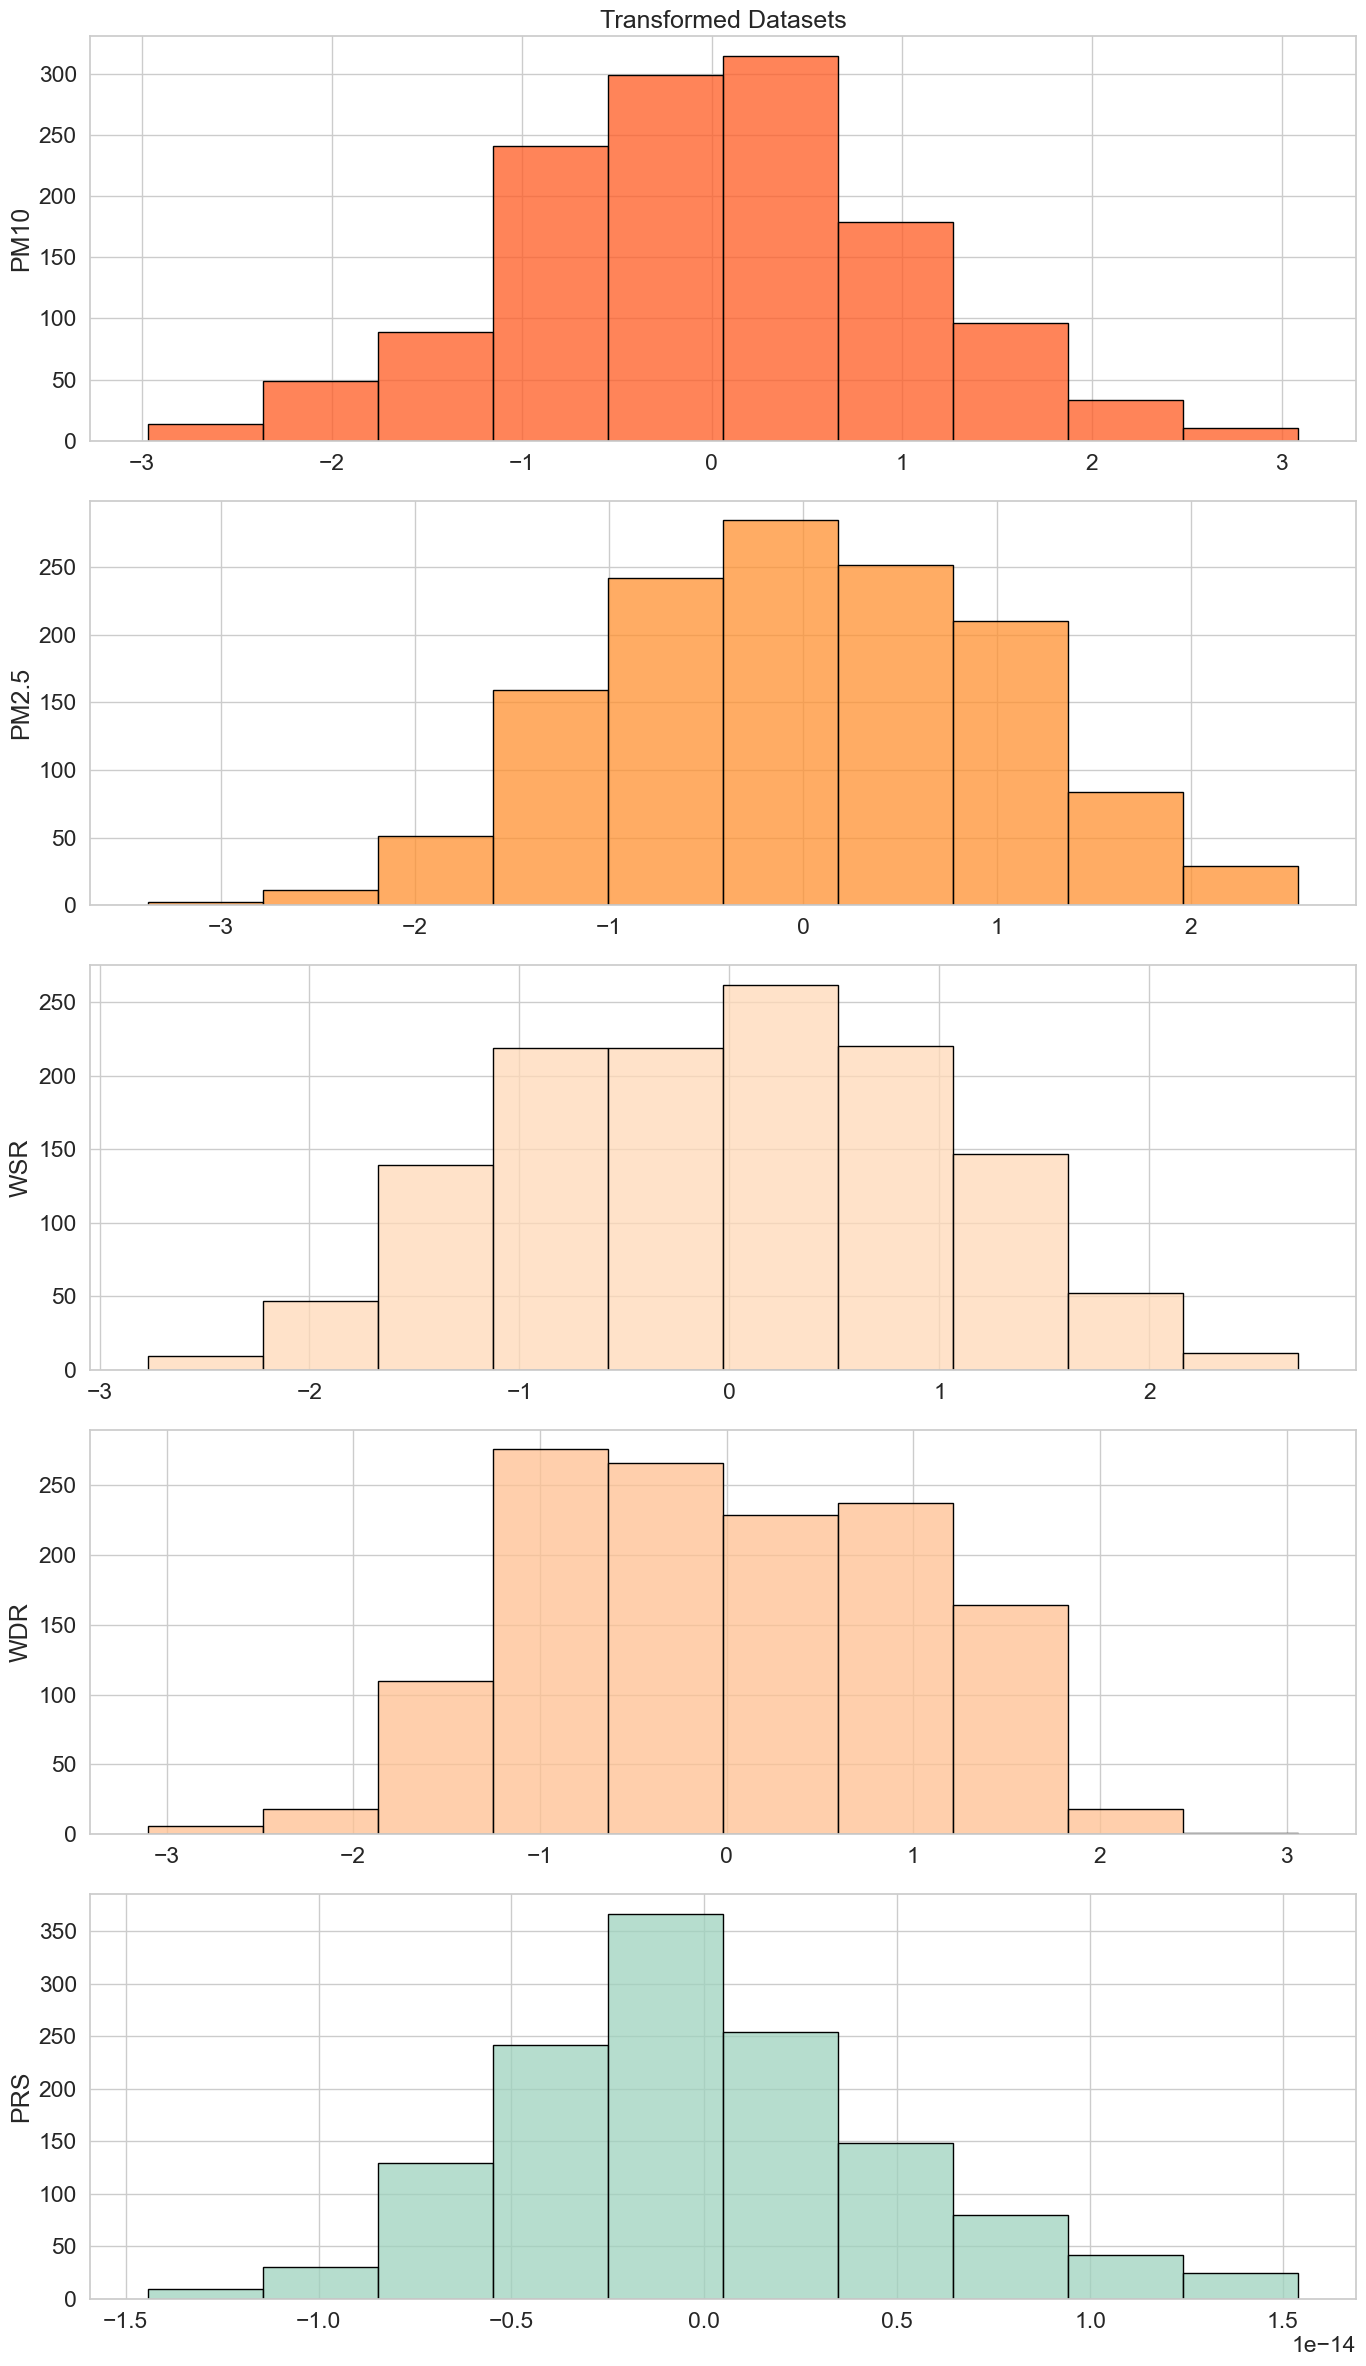

In [19]:
hist_plot(transformed_df['CENTRO'],INTEREST_VARS,"Transformed Datasets",bins=10)